In [20]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
n = 8
n_node = 8

In [3]:
K = tc.set_backend('jax')

In [4]:
# numpy data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
ind = y_test == 9
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_test == 8
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_train == 9
x_train, y_train = x_train[~ind], y_train[~ind]
ind = y_train == 8
x_train, y_train = x_train[~ind], y_train[~ind]

x_train = x_train / 255.0
mean = jnp.mean(x_train, axis=0)
x_train = x_train - mean
x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

x_test = x_test / 255.0
x_test = x_test - mean
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))

y_train = jax.nn.one_hot(y_train, n_node)

2022-07-29 19:28:23.251834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 19:28:26.268317: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-29 19:28:26.268384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29659 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:13:00.0, compute capability: 7.0


In [5]:
def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return -jnp.mean(y * jnp.log(probs) + (1 - y) * jnp.log(1 - probs))
loss = K.jit(loss, static_argnums=[3])

In [6]:
def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

In [7]:
k = 50

In [8]:
compute_loss = K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2])
compute_accuracy = K.vmap(accuracy, vectorized_argnums=[1, 2])

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0, 0/377: loss=0.4081, acc=0.3281
epoch 0, 30/377: loss=0.1793, acc=0.8047
epoch 0, 60/377: loss=0.1538, acc=0.8672
epoch 0, 90/377: loss=0.1450, acc=0.8906
epoch 0, 120/377: loss=0.1340, acc=0.8828
epoch 0, 150/377: loss=0.1290, acc=0.9219
epoch 0, 180/377: loss=0.1388, acc=0.8516
epoch 0, 210/377: loss=0.1213, acc=0.8906
epoch 0, 240/377: loss=0.1233, acc=0.8984
epoch 0, 270/377: loss=0.1212, acc=0.9297
epoch 0, 300/377: loss=0.1276, acc=0.8828
epoch 0, 330/377: loss=0.1298, acc=0.8594
epoch 0, 360/377: loss=0.1325, acc=0.8750
epoch 1, 0/377: loss=0.0992, acc=0.9219
epoch 1, 30/377: loss=0.1110, acc=0.9141
epoch 1, 60/377: loss=0.1111, acc=0.9141
epoch 1, 90/377: loss=0.1248, acc=0.8984
epoch 1, 120/377: loss=0.1093, acc=0.9609
epoch 1, 150/377: loss=0.1066, acc=0.9297
epoch 1, 180/377: loss=0.1150, acc=0.8828
epoch 1, 210/377: loss=0.1043, acc=0.9375
epoch 1, 240/377: loss=0.1237, acc=0.9062
epoch 1, 270/377: loss=0.1008, acc=0.9688
epoch 1, 300/377: loss=0.1069, acc=0.8984
ep

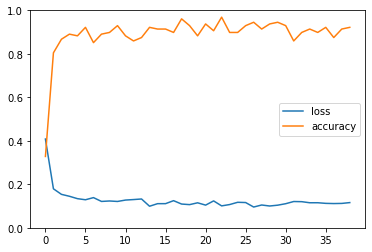

In [10]:
params_list = []
data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100).batch(128)

params = K.randn((k * 2, n), dtype=jnp.float32)
opt = optax.adam(learning_rate=1e-2)
opt_state = opt.init(params)

loss_list = []
acc_list = []
for e in tqdm(range(3), leave=False):
    for i, (x, y) in enumerate(data):
        x = x.numpy()
        y = y.numpy()
        loss_val, grad_val = compute_loss(params, x, y, k)
        updates, opt_state = opt.update(grad_val, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_mean = jnp.mean(loss_val)
        if i % 30 == 0:
            acc = jnp.mean(compute_accuracy(params, x, y, k))
            acc_list.append(acc)
            loss_list.append(loss_mean)
            print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')

plt.plot(loss_list)
plt.plot(acc_list)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 1)
plt.show()


In [13]:
def pred(params, x, k):
    c = tc.Circuit(n, inputs=x)
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    logits = []
    for i in range(n_node):
        logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
    logits = jnp.stack(logits, axis=-1) * 10
    probs = jax.nn.softmax(logits)
    return probs
pred = K.vmap(pred, vectorized_argnums=[1])

In [21]:
jnp.mean(pred(params, x_test[:1024], k).argmax(axis=-1) == y_test[:1024])

DeviceArray(0.8720703, dtype=float32)